In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
from lib.utils.data_spit import data_split

from lib.generators.LFR import LFR
from lib.generators.OLP import OLP

In [4]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# CLASSIFIER PARAMETERS
quality_class_intervals = [0, 0.25, 0.50, 0.75, 1.001]      # quality class intervals
quality_class_labels = [0, 1, 2, 3]                         # quality class labels
quality_class_names = ['exelent', 'good', 'ok', 'poor']     # quality classes names

# Step 1
## Graph and features generation

Generate/import graph and features based on avalible `generator` classes

In [6]:
generator = LFR(n=500, t1=3, t2=1.5, m=0.1, seed=seed)
#generator = OLP(network_index=0)

ground_truth_df = generator.get_df()

features_df = generator.get_features_df()
feature_names = generator.feature_names

feature_names

['com_ne',
 'short_path',
 'LHN',
 'page_rank_pers_edges',
 'pref_attach',
 'jacc_coeff',
 'adam_adar',
 'res_alloc_ind',
 'svd_edges',
 'svd_edges_dot',
 'svd_edges_mean']

In [47]:
ground_truth_df['goal'].value_counts()

1    1174
0    1174
Name: goal, dtype: int64

In [48]:
features_df.head(5)

,node1,node2,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,110,226,0.153846,0.0000,0.004310,0.002165,0.325614,0.097561,2.001291,0.148453,5.342948e-16,1.538462e-01,2.500000e-01
1,208,294,0.076923,0.0000,0.005698,0.002805,0.123158,0.081633,1.073632,0.097900,-1.908196e-16,7.692308e-02,1.481481e-01
2,184,272,0.000000,0.0002,0.000000,0.000523,0.076316,0.000000,0.000000,0.000000,-1.162265e-16,2.772762e-15,-4.660624e-17
3,207,212,0.038462,0.0000,0.004255,0.001144,0.082456,0.036364,0.617595,0.078462,2.636780e-16,3.846154e-02,2.000000e-01
4,83,103,0.596154,0.0000,0.011481,0.005127,0.473684,0.424658,7.500530,0.499587,1.110223e-16,5.961538e-01,5.740741e-01


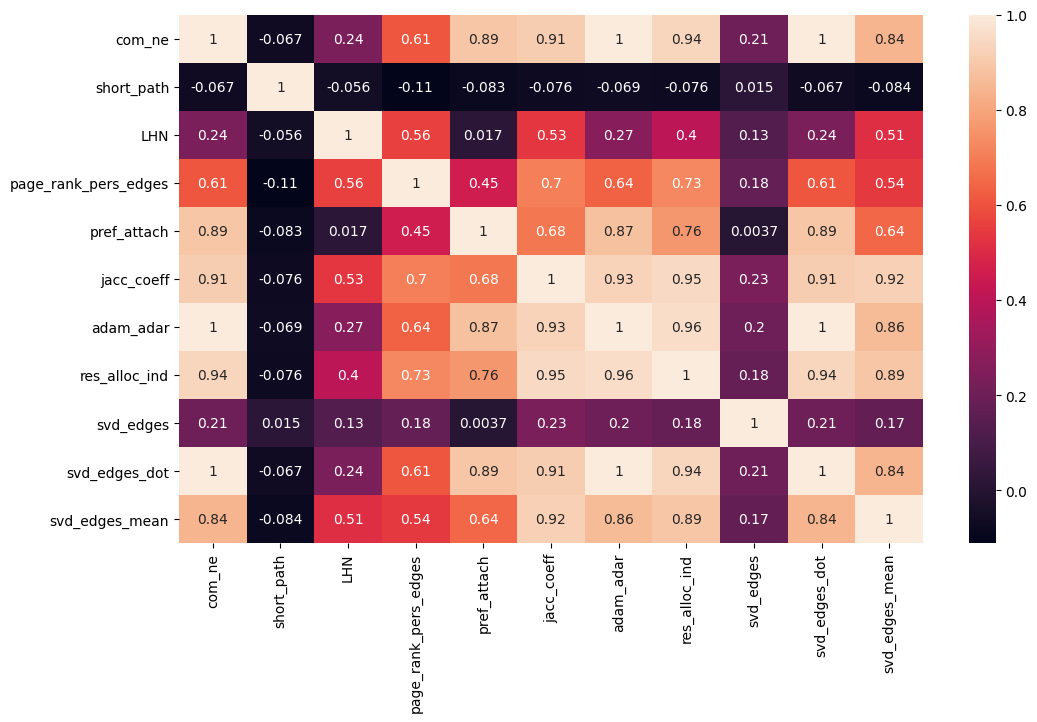

In [49]:
corrMatrix = features_df[feature_names].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Step 2
## Splitting the data

We split the data in the following way:
* 1/3 is used to train a link prediction model
* 1/3 is used to test the link prediction model. Here we also calculate the error and use this data to train quality classifier
* 1/3 is used to evaluate the clasifier

In [50]:
link_prediction_train, link_prediction_test, classifier_test = data_split(ground_truth_df, features_df)

In [51]:
link_prediction_train['goal'].value_counts()

1    390
0    390
Name: goal, dtype: int64

In [52]:
link_prediction_test['goal'].value_counts()

1    390
0    390
Name: goal, dtype: int64

In [53]:
classifier_test['goal'].value_counts()

1    390
0    390
Name: goal, dtype: int64

# Step 3
## Link prediction model

Predict links using one of the avalble link prediction models

In [66]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

TypeError: __init__() got an unexpected keyword argument 'X_train'

In [ ]:
print(f'Accuracy score on {len(link_prediction_test)} test samples:')
print(model.accuracy_score(link_prediction_test[feature_names], link_prediction_test['goal']))

Accuracy score on 780 test samples:
0.8666666666666667


# Step 4
## Quality class analisys

In [ ]:
from bisect import bisect

def quality_class_label(error): 
    return bisect(quality_class_intervals, error) - 1

In [ ]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba['quality_label'] = link_proba.apply(lambda row: quality_class_label(row['abs_error']), axis=1)
link_proba['quality_name'] = link_proba.apply(lambda row: quality_class_names[quality_class_label(row['abs_error'])], axis=1)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label,quality_name
0,22,147,0,0.000000,0.0002,0.000000,0.001787,0.100000,0.000000,0.000000,0.000000,4.822531e-16,3.022704e-15,1.992649e-17,0.00,0.00,0,exelent
1,228,259,0,0.038462,0.0000,0.002469,0.002167,0.142105,0.036364,0.554266,0.056005,-3.608225e-16,3.846154e-02,6.666667e-02,0.96,0.96,3,poor
2,187,294,0,0.057692,0.0000,0.006944,0.004715,0.075789,0.075000,0.945988,0.126407,-1.387779e-17,5.769231e-02,1.111111e-01,0.00,0.00,0,exelent
3,224,250,0,0.000000,0.0002,0.000000,0.001776,0.034737,0.000000,0.000000,0.000000,-6.297046e-16,2.925363e-15,-6.379927e-17,0.75,0.75,3,poor
4,32,228,0,0.000000,0.0002,0.000000,0.001254,0.075789,0.000000,0.000000,0.000000,-8.951173e-16,2.622274e-15,-3.642277e-16,0.00,0.00,0,exelent


In [ ]:
# statistics on error
link_proba['abs_error'].describe()

count    780.000000
mean       0.174744
std        0.265567
min        0.000000
25%        0.007500
50%        0.050000
75%        0.220000
max        1.000000
Name: abs_error, dtype: float64

Text(0, 0.5, 'Number of node pairs')

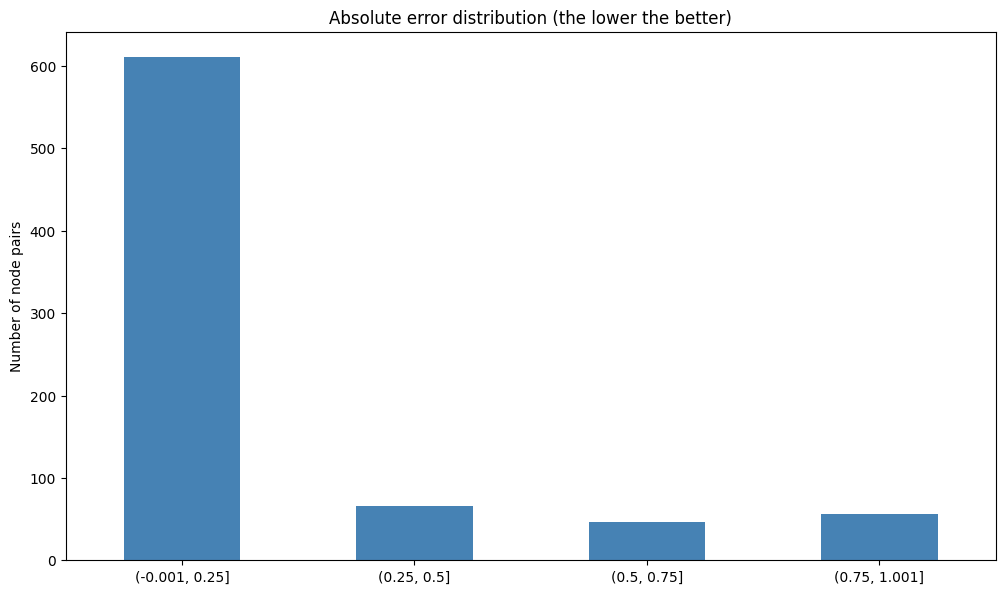

In [ ]:
# plot error distribution
fig, ax = plt.subplots()

pd.cut(link_proba['abs_error'], bins=quality_class_intervals, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color='steelblue', ax=ax)
ax.set_title("Absolute error distribution (the lower the better)")
ax.set_ylabel("Number of node pairs")

# Step 5
## Quality class prediction

In [ ]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = clf = DecisionTreeClassifier(random_state=seed)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, random_state=800)

In [ ]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = clf.predict_proba(classifier_test[feature_names])[:, 1]
proba = pd.Series(proba, name='prob')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: quality_class_label(row['true_abs_error']), axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,predicted_quality_label,true_abs_error,true_quality_label
0,103,286,0,0.000000,0.0002,0.000000,0.000310,0.085263,0.000000,0.000000,0.000000,-2.844947e-16,2.598514e-15,-5.208628e-16,0.003987,0,0.003987,0
1,134,178,0,0.000000,0.0002,0.000000,0.001015,0.180000,0.000000,0.000000,0.000000,-6.591949e-16,2.559378e-15,-3.053113e-16,0.266990,0,0.266990,1
2,12,164,0,0.000000,0.0004,0.000000,0.000182,0.021053,0.000000,0.000000,0.000000,-5.620504e-16,2.880798e-15,-6.153064e-16,0.007697,0,0.007697,0
3,196,227,0,0.076923,0.0000,0.003023,0.003207,0.232105,0.055556,1.024547,0.080951,-1.253338e-15,7.692308e-02,8.163265e-02,0.001424,0,0.001424,0
4,155,251,0,0.000000,0.0002,0.000000,0.000142,0.043509,0.000000,0.000000,0.000000,-4.787837e-16,2.829057e-15,-8.348357e-16,0.009810,0,0.009810,0


In [ ]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
0                     379
3                     375
1                      18
2                       8
dtype: int64

In [ ]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
0                          634
1                           72
2                           42
3                           32
dtype: int64

In [ ]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])
scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,780.000000
1,Accuracy,0.421795
2,Precision,0.256947
3,Recall,0.421795
4,F1 score,0.329394


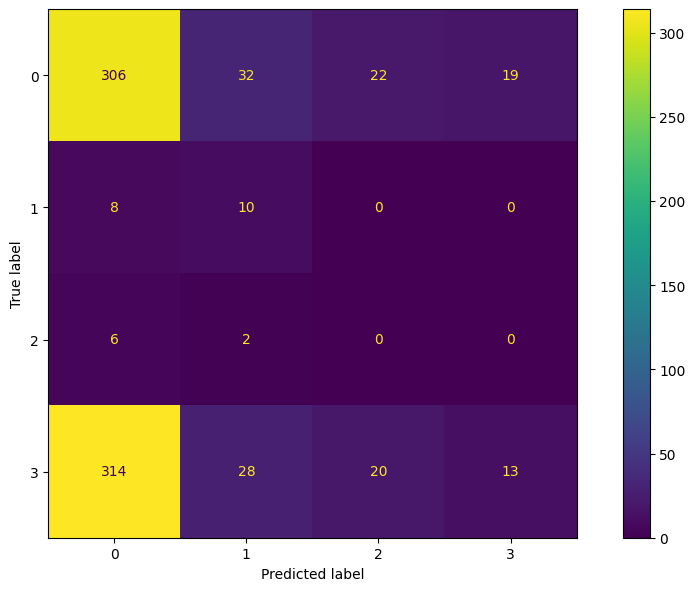

In [ ]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])